In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)
X=X/255 #Normalization
X,y=X.values, y.values
#Reshaping X
X = X.reshape(-1,28,28,1)
y = to_categorical(y)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=0)

X_train, X_val, y_train, y_val=train_test_split(X,y, test_size=10000, random_state=0)




In [7]:
len(X_val)

10000

### Model Definition

In [ ]:


model=Sequential([
        Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)),
        Conv2D(filters=64, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
        Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),

        Conv2D(filters=256, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),

        Flatten(),
        Dense(512,activation="relu"),
        Dense(256, activation="relu"),
        Dense(10,activation="softmax")
])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


### Image Argumentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=15,  
        zoom_range = 0.01, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False
    )  


train_gen = datagen.flow(X_train, y_train, batch_size=128)
val_gen = datagen.flow(X_val, y_val, batch_size=128)


In [ ]:
lr_callback = keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",          
        min_lr=0.00001,
     )

es = keras.callbacks.EarlyStopping(
        monitor="accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

history = model.fit(train_gen, 
                    epochs = 50, 
                    steps_per_epoch = X_train.shape[0] // 128,
                    validation_data = val_gen,
                    validation_steps = X_val.shape[0]//128, 
                    callbacks=[lr_callback, es])

Epoch 1/50
468/468 [==============================] - 25s 52ms/step - loss: 0.1382 - accuracy: 0.9576 - val_loss: 0.1194 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 2/50
468/468 [==============================] - 21s 45ms/step - loss: 0.0573 - accuracy: 0.9828 - val_loss: 0.0844 - val_accuracy: 0.9749 - lr: 0.0010
Epoch 3/50
468/468 [==============================] - 22s 47ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0733 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 4/50
468/468 [==============================] - 24s 51ms/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.0587 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 5/50
468/468 [==============================] - 25s 54ms/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.0469 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/50
468/468 [==============================] - 21s 45ms/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0363 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 7/50
468/468 [==============================] - 24s 

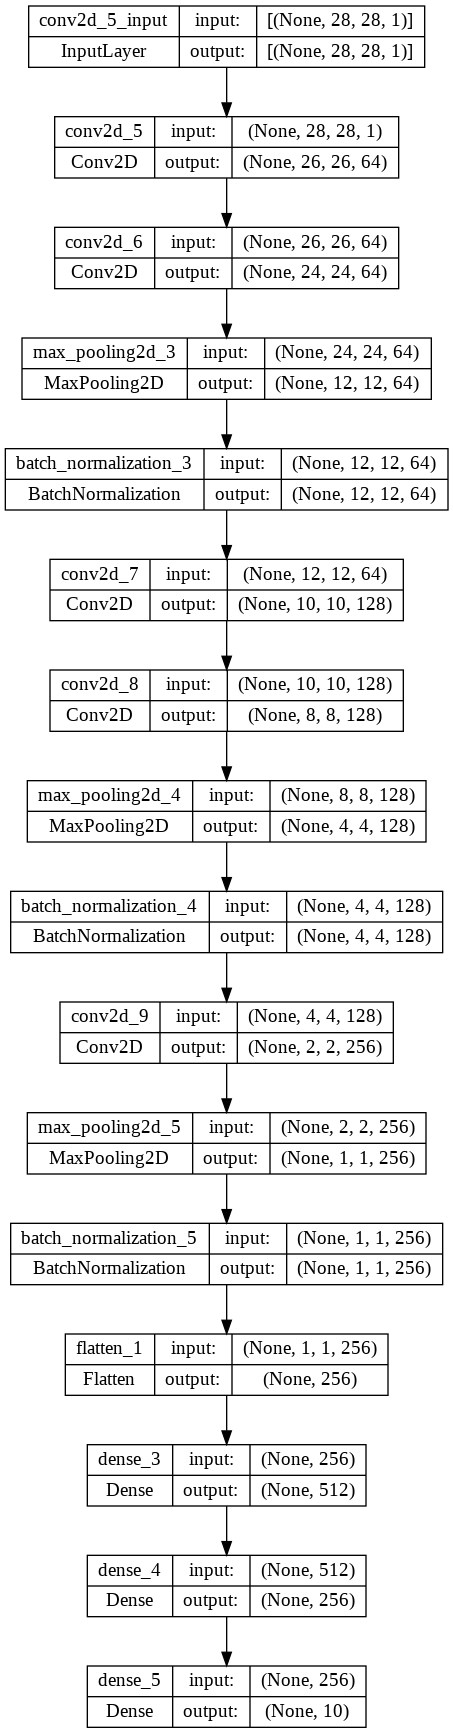

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)


In [ ]:
loss, acc= model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0185 - accuracy: 0.9957


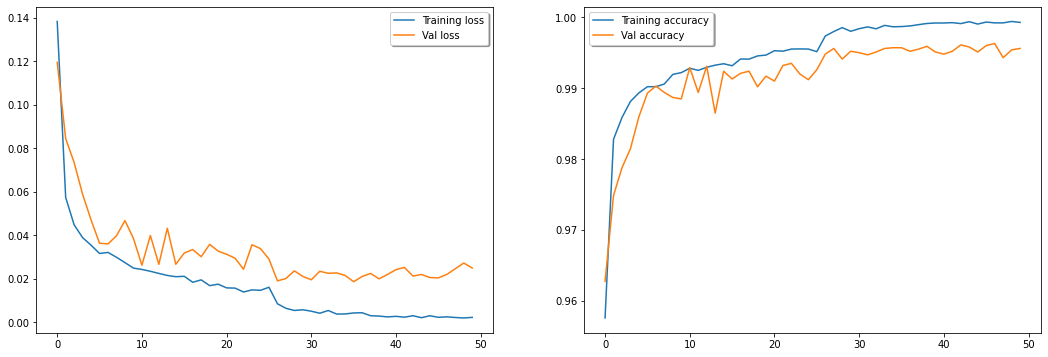

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1,2, figsize=(18, 6))
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'],  label="Val loss")

#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], label="Val accuracy")

#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

313/313 [==============================] - 1s 2ms/step


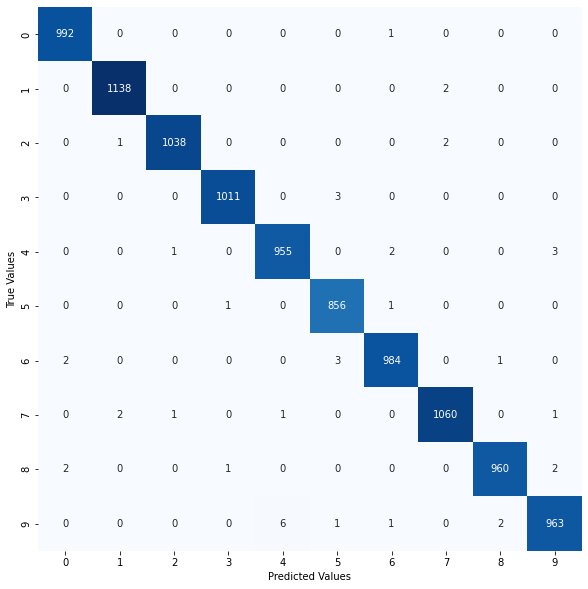

In [ ]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

313/313 [==============================] - 1s 2ms/step


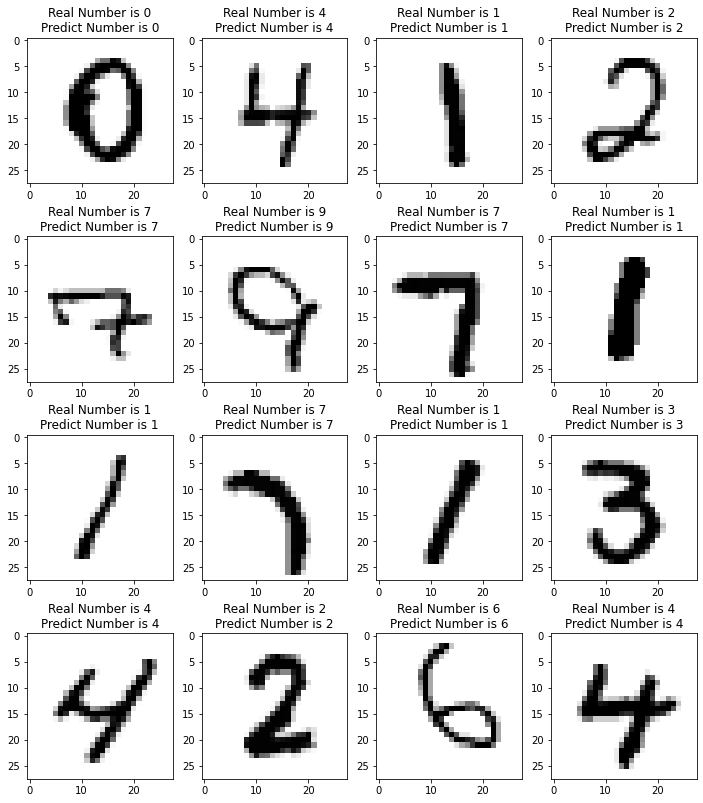

In [ ]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

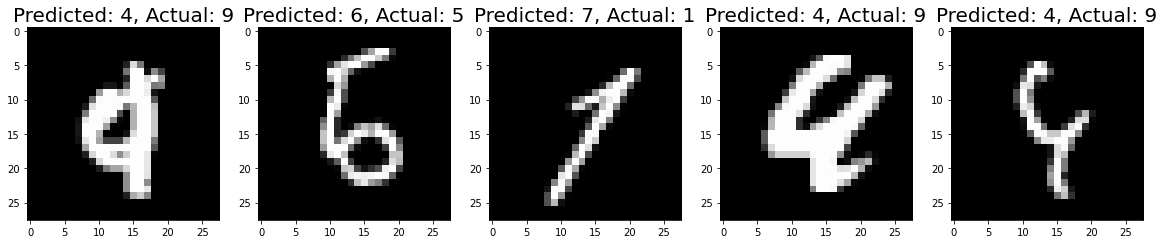

In [ ]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_pred):
    if label.argmax() != predict.argmax(): 
        misclassifiedIndexes.append(index)
    index +=1


plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(pd.Series(misclassifiedIndexes).sample(25)):
    plt.subplot(5, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(y_pred[badIndex].argmax(), y_test[badIndex].argmax()), fontsize = 20)


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize the pixel values
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape the images to have a single channel
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

# Build the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1428 - accuracy: 0.9559
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0454 - accuracy: 0.9861
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0327 - accuracy: 0.9893
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0251 - accuracy: 0.9920
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0253 - accuracy: 0.9926
Test accuracy: 0.9926000237464905
